# 随机森林分类

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from read_5500_data import get_5500_data

% matplotlib inline

随机森林是一个非常简单, 效果又不错的分类器. 可以作为机器学习的基准. 如果随机森林的分类器仍然不好用, 推荐使用深度神经网络了. 

评估一个模型的优劣, 要看ROC曲线的形态和AUC分数

* ROC曲线越靠近左上越好, 
* AUC就是ROC曲线下面积, 越大越好, 最大值=1

## 读取数据

In [2]:
data_path="data_sim" # "data_sim"是模拟数据目录
class_file="class_sim.csv" # "class_sim.cs"是模拟分类说明文件
X,y=get_5500_data(data_path,class_file, 
                 start_time=0,duration=5, # 按照时间截取数据, 设置截取的初始时间和时间长度
                 redundancy=5, # 截取后数据长度可能不一致, 统一补全到duration*5+redundancy的长度
                 padding_with="last" # 以最后一个有效数据补全
                 )

## 分拆数据

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                X, y, test_size=0.2) # 总数据中有20%的数据作为测试集

## 建立并训练模型
此处使用的是随机森林分类器的默认设置. 如果运算过程太长, 或者评估不理想, 也可以考虑调整其中的参数

In [9]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train);

## 评估模型

In [5]:
y_pred=clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
print("AUC=",auc(fpr_rf, tpr_rf))

AUC= 1.0


## ROC曲线

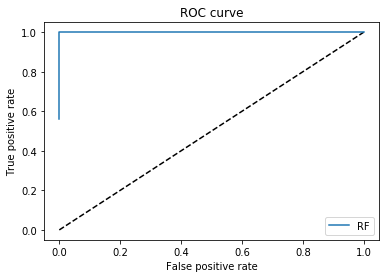

In [6]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 对随机森林的参数优化

注意, 本部分并非必须. 

通常随机森林的默认参数已经可以达到较好的分类效果. 
* 例如如果AUC评分已经>0.85甚至>0.9, 临床上已经近乎可以实用, 发SCI paper也绰绰有余. 个人认为调整参数的意义不大. 
* 而如果AUC评分极低, 例如仅仅略高于0.5, 
    * 要么输入的信息X中并没有包含可以推知y的所有信息, 还有较大的信息缺失, 
    * 要么就是"传统的机器学习方法"已经无法胜任, 还不如及时更换成深度学习模型
    

## 常见需要调整的参数

按照外科系统"know nothing but do everything"的传统, 各位眼科医生通常不想知道为什么去调整这些参数. 所以我只在这里讲解大概参数调整的方向和意义. 

* n_estimators: 所谓随机森林是很多个"决策树"组合在一起的, 这里的n_estimators就是说有多少个决策树, 默认是10棵树. 
    * 如果n_estimators太小, 就不能解决复杂的问题, 所谓"欠拟合". 但是速度快. 
    * 如果n_estimators太大, 能够解决复杂问题, 但计算量就太大, 成本很高. 因此, 如果你的问题复杂, 可以增加n_estimators, 如果嫌弃算得太慢, 要么去卖更高级的电脑, 要么减少n_estimators. 

* max_features: 
    * 如果max_features=1, 每一个决策树都非常复杂. ->能够应对复杂问题, 但运算速度慢
    * 如果max_features = 接近可能的feature总数, 每一个决策树都非常简单. -> 运算速度快, 但不能应对复杂问题. 
    
* max_depth: 决策树的最大深度, 如果嫌弃算得太慢, 要么去卖更高级的电脑, 要么减少. 默认不限制. 
    * 如果max_depth减小, 运算速度快, 但不能应对复杂问题
    * 如果max_depth增大, 能够对付复杂问题, 但是慢. 

* n_jobs: 如果做并行计算, 有多少个核去参与. 大概是有钱就增大吧. 

更多的信息, 请参考scikit_learn中关于[随机森林的说明](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), 这里有一篇关于参数调整的[blog](http://www.cnblogs.com/pinard/p/6160412.html), 讲得也不错. 总的来说, 如果你觉得随机森林分类器不够好, 那么增加树木, 使每一棵树变得更高更繁茂, 但要花费更多的时间或者金钱. 

比如默认值是：
```python
clf = RandomForestClassifier(n_estimators=10,max_features=’auto’,max_depth=None,n_jobs=1)
clf.fit(X_train, y_train)
```

你嫌弃AUC分数太低, 那么可以调整为: 
```python
clf = RandomForestClassifier(n_estimators=30,max_features=’auto’,max_depth=None,n_jobs=4)
clf.fit(X_train, y_train)
```
或者, 你觉得算得太慢, 看不到结果, 那么可以调整为: 
```python
clf = RandomForestClassifier(n_estimators=8,max_features=’auto’,max_depth=3,n_jobs=8)
clf.fit(X_train, y_train)
```